In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files  # 코랩 파일 업로드/다운로드용

# 1. 파일 업로드 단계
print("--- 필수 CSV 파일을 업로드하세요 (base_preprocessed.csv, train_smote.csv, train_cgan.csv, test_smote.csv) ---")
uploaded = files.upload()

# 2. TabTransformer 구조 정의
class TabTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=32, num_heads=8, num_layers=4):
        super(TabTransformer, self).__init__()
        self.numerical_projection = nn.Linear(input_dim, input_dim * embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim * embed_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.numerical_projection(x).view(x.size(0), -1, 32)
        x = self.transformer(x)
        x = x.flatten(1)
        return self.mlp(x)

# 3. 메인 실행 함수
def run_tabtransformer_on_colab():
    # GPU 체크
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ 현재 사용 중인 디바이스: {device}")
    if device.type != 'cuda':
        print("⚠️ 주의: GPU가 비활성화 상태입니다. 상단 메뉴 [수정] -> [노트 설정]에서 T4 GPU를 선택하세요.")

    # 공통 테스트 데이터 로드
    test_df = pd.read_csv("test_smote.csv")
    X_test_all = torch.FloatTensor(test_df.drop('Class', axis=1).values).to(device)
    y_test_all = test_df['Class'].values

    dataset_configs = {
        "Original": "base_preprocessed.csv",
        "SMOTE": "train_smote.csv",
        "cGAN": "train_cgan.csv"
    }

    results_files = [] # 다운로드할 파일 목록

    for name, filename in dataset_configs.items():
        if not os.path.exists(filename):
            print(f"⏭️ {filename} 파일이 없어 {name}을(를) 건너뜁니다.")
            continue

        print(f"\n🔥 [{name}] 학습 시작 (100 Epochs)")
        df = pd.read_csv(filename)

        if name == "Original":
            train_df, _ = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])
        else:
            train_df = df

        X_tr = torch.FloatTensor(train_df.drop('Class', axis=1).values).to(device)
        y_tr = torch.FloatTensor(train_df['Class'].values).view(-1, 1).to(device)
        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=1024, shuffle=True)

        model = TabTransformer(input_dim=X_tr.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.BCELoss()

        best_f1 = 0.0
        best_state_dict = None
        best_threshold = 0.5

        model.train()
        for epoch in range(1, 101):
            epoch_loss = 0
            for batch_x, batch_y in train_loader:
                optimizer.zero_grad()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            # 10에포크마다 검증
            if epoch % 10 == 0:
                model.eval()
                with torch.no_grad():
                    y_probs = model(X_test_all).cpu().numpy().flatten()

                precisions, recalls, thresholds = precision_recall_curve(y_test_all, y_probs)
                f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
                idx = np.argmax(f1_scores)
                current_f1 = f1_scores[idx]

                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_state_dict = model.state_dict().copy()
                    best_threshold = thresholds[idx] if idx < len(thresholds) else 0.5
                    print(f"   ⭐ Epoch {epoch:3d} | New Best F1: {best_f1:.4f}")

                model.train()

        # 최종 저장 및 메타데이터 구성
        save_filename = f"tabtransformer_model_{name.lower()}.pkl"
        model_metadata = {
            "model_type": "TabTransformer",
            "augmentation": name,
            "input_dim": X_tr.shape[1],
            "model_state_dict": best_state_dict,
            "threshold": best_threshold,
            "feature_names": list(train_df.drop('Class', axis=1).columns)
        }

        with open(save_filename, "wb") as f:
            pickle.dump(model_metadata, f)

        results_files.append(save_filename)
        print(f"✅ [{name}] 학습 완료 및 {save_filename} 생성")

    # 모든 학습 종료 후 파일 자동 다운로드
    print("\n📥 생성된 모델 파일을 다운로드합니다...")
    for f_name in results_files:
        files.download(f_name)

if __name__ == "__main__":
    run_tabtransformer_on_colab()

--- 필수 CSV 파일을 업로드하세요 (base_preprocessed.csv, train_smote.csv, train_cgan.csv, test_smote.csv) ---


--- 원본(base_preprocessed.csv)과 증강 파일들을 업로드하세요 ---


Saving base_preprocessed.csv to base_preprocessed.csv
Saving test_cgan.csv to test_cgan.csv
Saving test_smote.csv to test_smote.csv
Saving train_cgan.csv to train_cgan.csv
Saving train_smote.csv to train_smote.csv
✅ 원본 사기 데이터 로드 완료

📊 [1. Statistical Distance] 통계적 유사도 (낮을수록 좋음)
Dataset    | Frechet Distance (FD)    
----------------------------------------


/tmp/ipython-input-1965333235.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


SMOTE      | 1.6465


/tmp/ipython-input-1965333235.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


cGAN       | 644.4922

🎨 [2. t-SNE Visualization] 분포 겹침 확인


/tmp/ipython-input-1965333235.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
/tmp/ipython-input-1965333235.py:28: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)


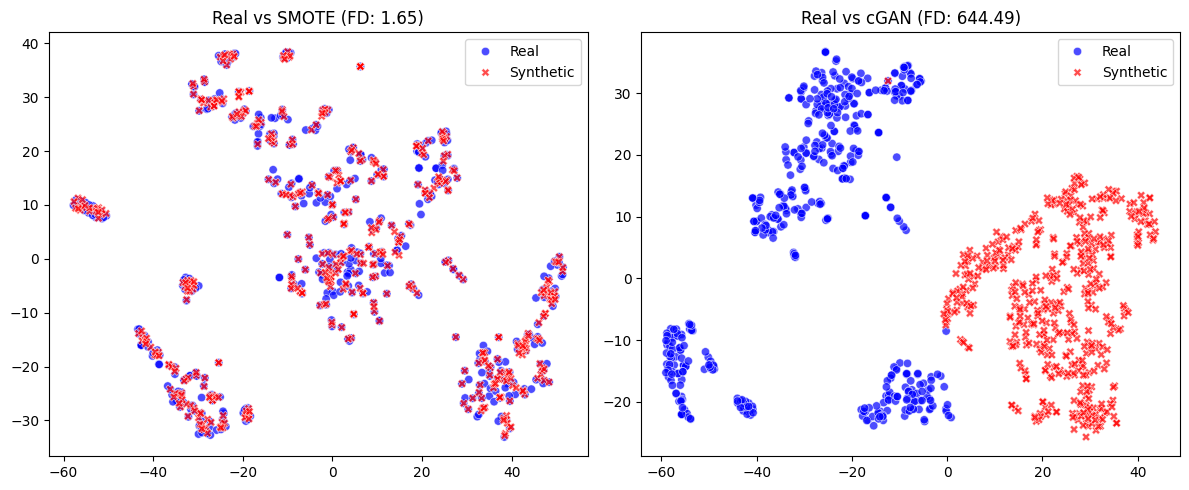

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import linalg
from sklearn.manifold import TSNE
from scipy.spatial.distance import jensenshannon
from google.colab import files

print("--- 원본(base_preprocessed.csv)과 증강 파일들을 업로드하세요 ---")
uploaded = files.upload() # 이미 업로드했다면 주석 처리

# 1. Fréchet Distance 계산 함수 (Tabular 데이터용)
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance."""
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight complex component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError(f"Imaginary component {m}")
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean

def evaluate_statistical_quality():
    # 데이터 로드
    try:
        real_df = pd.read_csv("base_preprocessed.csv")
        # 사기 데이터(Class=1)에 대해서만 품질을 검증하는 것이 일반적입니다.
        real_fraud = real_df[real_df['Class'] == 1].drop('Class', axis=1)
        print("✅ 원본 사기 데이터 로드 완료")
    except:
        print("❌ base_preprocessed.csv가 필요합니다.")
        return

    datasets = {
        "SMOTE": "train_smote.csv",
        "cGAN": "train_cgan.csv",
        # "K-cGAN": "train_kcgan.csv"
    }

    print("\n📊 [1. Statistical Distance] 통계적 유사도 (낮을수록 좋음)")
    print(f"{'Dataset':<10} | {'Frechet Distance (FD)':<25}")
    print("-" * 40)

    for name, filename in datasets.items():
        if not os.path.exists(filename): continue

        fake_df = pd.read_csv(filename)
        # 증강된 데이터 중 사기 데이터만 추출
        fake_fraud = fake_df[fake_df['Class'] == 1].drop('Class', axis=1)

        # 1. Mean & Covariance 계산
        mu_real, sigma_real = real_fraud.mean(axis=0), real_fraud.cov()
        mu_fake, sigma_fake = fake_fraud.mean(axis=0), fake_fraud.cov()

        # 2. Frechet Distance 계산
        fd_score = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)

        print(f"{name:<10} | {fd_score:.4f}")

    print("\n🎨 [2. t-SNE Visualization] 분포 겹침 확인")
    plt.figure(figsize=(12, 5))

    # 시각화용 샘플링 (속도 위해 500개만)
    n_samples = 500
    real_sample = real_fraud.sample(n=min(n_samples, len(real_fraud)), random_state=42)

    plot_idx = 1
    for name, filename in datasets.items():
        if not os.path.exists(filename): continue

        fake_df = pd.read_csv(filename)
        fake_fraud = fake_df[fake_df['Class'] == 1].drop('Class', axis=1)
        fake_sample = fake_fraud.sample(n=min(n_samples, len(fake_fraud)), random_state=42)

        # 데이터 합치기
        combined = pd.concat([real_sample, fake_sample])
        labels = ['Real'] * len(real_sample) + ['Synthetic'] * len(fake_sample)

        # t-SNE 실행
        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        tsne_res = tsne.fit_transform(combined)

        plt.subplot(1, len(datasets), plot_idx)
        sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=labels, style=labels, alpha=0.7, palette={'Real':'blue', 'Synthetic':'red'})
        plt.title(f"Real vs {name} (FD: {calculate_frechet_distance(mu_real, sigma_real, fake_fraud.mean(axis=0), fake_fraud.cov()):.2f})")
        plot_idx += 1

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    import os
    evaluate_statistical_quality()